 Versuch 2
 ======
 
 Thema
 ------

Ziel dieses Versuchs ist es mit Hilfe von Clusteranalyse die Merkmale der aufgezeichneten Daten in unterschiedliche   
Rauhigkeitsklassen zu unterteilen. Die Fragestellung ist wie gut die Merkmale mit Clustering gelabelt werden können. Die zu analysierenden   
Daten wurde vorher mit einer Android App aufgenommen.   


 Versuchsaufbau
 ------
 
Die erfassten Daten sollen mit Clustering gelabelt werden. Dafür werden die zu betrachtenden Daten in Form einer bereits bearbeiteten CSV geladen.    
Durch Plots und Informationen der Daten soll analysiert werden, ob die gefunden Klassen sin ergeben. Zu weiteren Verarbeitung der Daten sollen      
die Merkmale um eine Spalte erweitert werden, um die zugeordneten Klassen abzuspeichern. Als Algorithmus wird KMeans verwendet mit der Implementierung von scikit-learn.  


In [1]:
# Bibliotheken laden
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipyleaflet import *
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.externals import joblib
from scipy.interpolate import interp1d
import pandas

In [2]:
# Läd alle Messwerte
accXDf = pandas.read_csv("../daten/accX.csv")
accYDf = pandas.read_csv("../daten/accY.csv")
accZDf = pandas.read_csv("../daten/accZ.csv")
pitchDf = pandas.read_csv("../daten/nick.csv")
rollDf = pandas.read_csv("../daten/roll.csv")
azimuthDf = pandas.read_csv("../daten/azimuth.csv")
sensorTimestampsDf = pandas.read_csv("../daten/sensorTimestamps.csv")

In [3]:
# Lesen der Merkmale
featuresDf = pandas.read_csv("../daten/merkmale.csv")
featuresDf.describe()

,Zeitstempel,Breitengrad,Laengengrad,Geschwindigkeit,Messwerte,StartZeitfenster,StartBewegungsdaten,StartBelichtung,Belichtungszeit,MittelX,...,VarianzY,VarianzZ,VarianzNick,VarianzRoll,AbweichungX,AbweichungY,AbweichungZ,AbweichungNick,AbweichungRoll,Klasse
count,4.983200e+04,49832.000000,49832.000000,49832.000000,49832.000000,4.983200e+04,4.983200e+04,4.983200e+04,4.983200e+04,49832.000000,...,49832.000000,49832.000000,49832.000000,49832.000000,49832.000000,49832.000000,49832.000000,49832.000000,49832.000000,49832.000000
mean,1.521224e+12,53.606883,10.128745,14.058019,19.370846,7.614164e+13,7.614158e+13,7.614167e+13,1.268842e+07,0.000790,...,14.723813,23.538971,0.184945,0.357644,1.271363,3.129074,4.013120,0.390157,0.410538,0.328444
std,7.273196e+07,0.027369,0.058248,3.550545,0.613684,3.221526e+13,3.221526e+13,3.221526e+13,7.765416e+06,0.275011,...,28.194370,38.083029,0.159720,0.677508,0.826031,2.220993,2.726534,0.180895,0.434864,0.571429
min,1.521124e+12,53.557396,10.002181,5.004000,6.000000,2.999506e+13,2.999499e+13,2.999509e+13,9.376720e+05,-3.293572,...,0.006190,0.037990,0.000560,0.000150,0.095860,0.078680,0.194910,0.023660,0.012250,0.000000
25%,1.521128e+12,53.579277,10.091159,11.700000,19.000000,3.372892e+13,3.372885e+13,3.372895e+13,7.979408e+06,-0.149861,...,2.912230,4.587890,0.058858,0.012930,0.720560,1.706530,2.141935,0.242605,0.113710,0.000000
50%,1.521212e+12,53.613132,10.140025,14.256000,19.000000,7.307148e+13,7.307141e+13,7.307151e+13,1.000184e+07,0.001516,...,6.394805,10.401200,0.136260,0.040700,1.060295,2.528795,3.225090,0.369130,0.201745,0.000000
75%,1.521297e+12,53.626503,10.162369,16.596000,20.000000,1.079068e+14,1.079067e+14,1.079068e+14,2.000368e+07,0.153405,...,14.631225,25.147705,0.271390,0.338215,1.579783,3.825080,5.014750,0.520950,0.581565,1.000000
max,1.521302e+12,53.656776,10.229659,24.804000,48.000000,1.122372e+14,1.122371e+14,1.122372e+14,3.287369e+07,2.180541,...,506.214760,591.058180,1.242630,5.975190,13.494720,22.499220,24.311690,1.114730,2.444420,2.000000


In [4]:
featuresDf.Breitengrad.shape[0]

49832

In [5]:
data = np.asarray([featuresDf.Geschwindigkeit,featuresDf.AbweichungX,featuresDf.AbweichungY,featuresDf.AbweichungZ])
data = scale(data)
data = data.T

In [6]:
%%time
y_pred = KMeans(n_clusters=3, max_iter=300, n_init=10).fit_predict(data)

Wall time: 802 ms


Text(0.5,1,'KMeans')

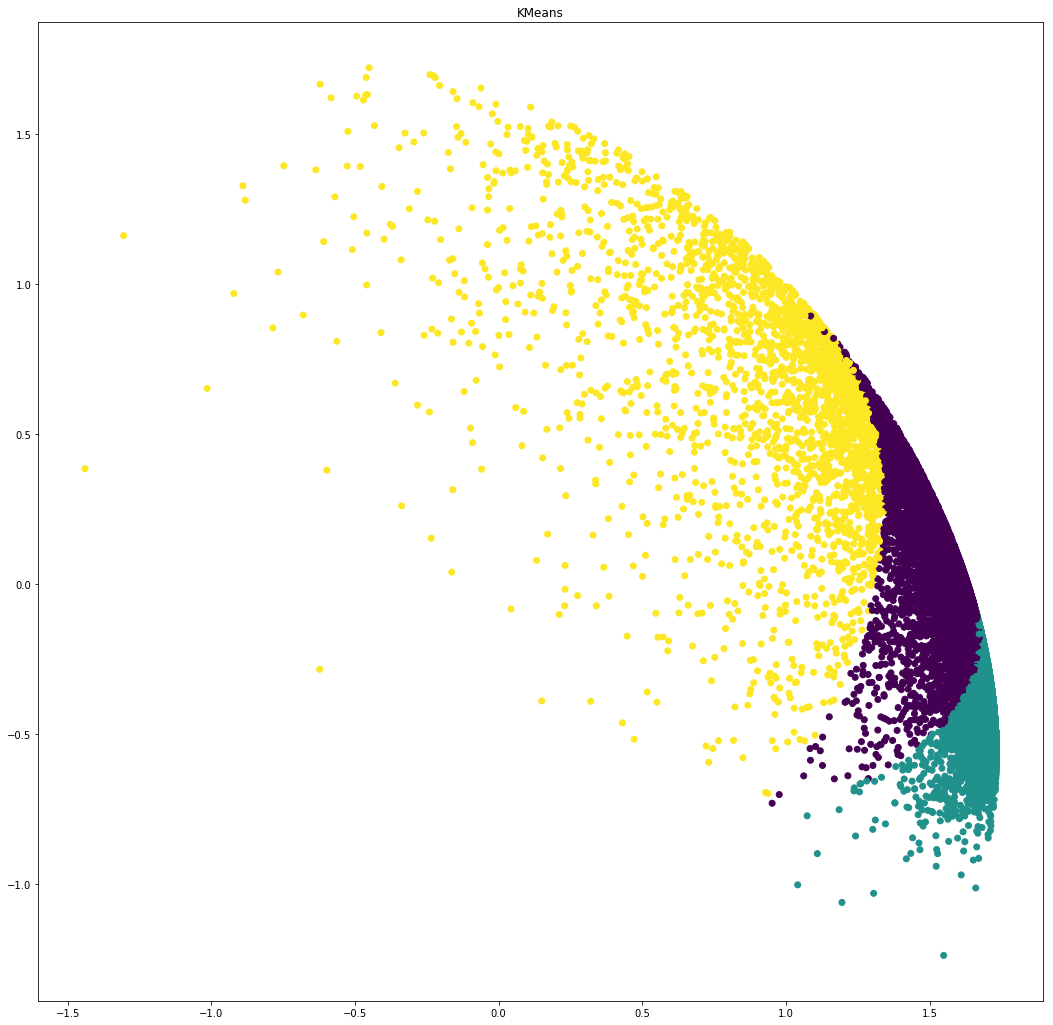

In [10]:
fig, ax = plt.subplots(figsize=(18, 18))
ax.scatter(data[:,0],data[:,3],c=y_pred)
plt.title("KMeans")

In [8]:
y_pred[2000]

1

In [9]:
# Speichert Plot ab
fig.savefig('versuch2_KMeans')

In [10]:
# Speichert das Ergebnis des Modells ab
filename = "KMeans"
joblib.dump(y_pred, filename)

['KMeans']

In [39]:
# Läd Vorhersage
y_predLoad = joblib.load(filename)

In [13]:
# Lade Bilder in eine Liste
images = []
# Hier können die Datensätze ausgewählt werden
datasets = ['15','16','17']
# Die Pfade zu den Ordnern in welchem sich die Bilder befinden
paths = []
for dataset in datasets: # Für jeden Datensatz merke Pfad
    paths.append("E:/bachelor/daten/" + dataset + "/zugeschnitten/")
for path in paths: # Für jeden Pfad hole die Namen der Ordner
    folders = os.listdir(path)
    for folder in folders: # Aus der Liste der Ordner wird ein Ordner ausgewählt
        filesPath = path + folder + "/"
        print(filesPath)
        files = os.listdir(filesPath)
        for name in files: # Ein Dateiname aus diesem Ordner
            if "jpg" not in name:
                continue
            images.append(cv2.imread(filesPath + name, cv2.COLOR_BGR2GRAY)) # Bild wird gelesen

E:/bachelor/daten/15/zugeschnitten/1/
E:/bachelor/daten/15/zugeschnitten/2/
E:/bachelor/daten/15/zugeschnitten/3/
E:/bachelor/daten/15/zugeschnitten/4/
E:/bachelor/daten/15/zugeschnitten/5/
E:/bachelor/daten/15/zugeschnitten/6/
E:/bachelor/daten/15/zugeschnitten/7/
E:/bachelor/daten/15/zugeschnitten/8/
E:/bachelor/daten/16/zugeschnitten/1/
E:/bachelor/daten/16/zugeschnitten/2/
E:/bachelor/daten/16/zugeschnitten/3/
E:/bachelor/daten/16/zugeschnitten/4/
E:/bachelor/daten/16/zugeschnitten/5/
E:/bachelor/daten/16/zugeschnitten/6/
E:/bachelor/daten/16/zugeschnitten/7/
E:/bachelor/daten/16/zugeschnitten/8/
E:/bachelor/daten/17/zugeschnitten/1/
E:/bachelor/daten/17/zugeschnitten/10/
E:/bachelor/daten/17/zugeschnitten/11/
E:/bachelor/daten/17/zugeschnitten/12/
E:/bachelor/daten/17/zugeschnitten/2/
E:/bachelor/daten/17/zugeschnitten/3/
E:/bachelor/daten/17/zugeschnitten/4/
E:/bachelor/daten/17/zugeschnitten/5/
E:/bachelor/daten/17/zugeschnitten/6/
E:/bachelor/daten/17/zugeschnitten/7/
E:/bachel

In [16]:
# Index von welchem die Messwerte dargestellt werden sollen
row = 20000
# Der erste und letzte Zeitstempel der Messwerte
timestampsMinMax = [sensorTimestampsDf.iloc[row,1],sensorTimestampsDf.iloc[[row]].dropna(axis=1, how='any').iloc[0,-1]]
# Belichtungszeit vom Start bis zum Ende
startExposureTime = featuresDf.StartBelichtung.iloc[row] - featuresDf.StartZeitfenster.iloc[row]
exposureTime = [startExposureTime,startExposureTime + featuresDf.Belichtungszeit.iloc[row]]
# Interpolation der Diskreten Werten, entfernen von NaN Werten und Konvertierung der Daten in Numpy Arrays 
npTimestamps = np.asarray(sensorTimestampsDf.iloc[[row]].dropna(axis=1, how='any')).squeeze()
fAccX = interp1d(npTimestamps,np.asarray(accXDf.iloc[[row]].dropna(axis=1)).squeeze())
fAccY = interp1d(npTimestamps,np.asarray(accYDf.iloc[[row]].dropna(axis=1)).squeeze())
fAccZ = interp1d(npTimestamps.squeeze(),np.asarray(accZDf.iloc[[row]].dropna(axis=1)).squeeze())
fNick = interp1d(npTimestamps,np.asarray(pitchDf.iloc[[row]].dropna(axis=1)).squeeze())
fRoll = interp1d(npTimestamps,np.asarray(rollDf.iloc[[row]].dropna(axis=1)).squeeze())
fAzimuth = interp1d(npTimestamps,np.asarray(azimuthDf.iloc[[row]].dropna(axis=1)).squeeze())
xnew = np.arange(timestampsMinMax[0],timestampsMinMax[1],1000)

<Figure size 720x720 with 0 Axes>

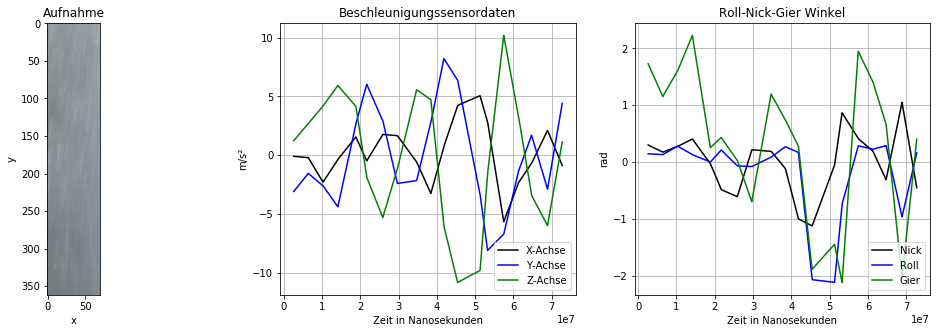

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[53.654667000000003, 10.160888999999999], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']), Marker(location=[53.654667000000003, 10.160888999999999], opacity=0.5, options=['alt', 'clickable', 'draggable', 'keyboard', 'rise_offset', 'rise_on_hover', 'title', 'z_index_offset'])), layout=Layout(height='300px', width='1000px'), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=16)

In [17]:
# Mit Hilfe eines Subplots werden übersichtlich mehrere Grafiken geplottet
plt.figure(0, figsize=(10,10))
f, axarr = plt.subplots(1, 3,figsize=(18,5))
axarr[0].imshow(images[row], cmap='gray')
axarr[0].set_title('Aufnahme')
axarr[0].set_xlabel('x')
axarr[0].set_ylabel('y')
axarr[1].plot(xnew,fAccX(xnew),color='black', linestyle='-', label='X-Achse')
axarr[1].plot(xnew,fAccY(xnew),color='blue', linestyle='-', label='Y-Achse')
axarr[1].plot(xnew,fAccZ(xnew),color='green', linestyle='-', label='Z-Achse')
axarr[1].set_title('Beschleunigungssensordaten')
axarr[1].set_xlabel('Zeit in Nanosekunden')
axarr[1].set_ylabel('m/s²')
axarr[1].grid(True)
axarr[1].legend(loc='lower right', framealpha=0.8)
axarr[2].plot(xnew,fNick(xnew), color='black', linestyle='-', label='Nick')
axarr[2].plot(xnew,fRoll(xnew), color='blue', linestyle='-', label='Roll')
axarr[2].plot(xnew,fAzimuth(xnew), color='green', linestyle='-', label='Gier')
axarr[2].set_title('Roll-Nick-Gier Winkel')
axarr[2].set_xlabel('Zeit in Nanosekunden')
axarr[2].set_ylabel('rad')
axarr[2].grid(True)
axarr[2].legend(loc='lower right', framealpha=0.8)
plt.show()
# Abstand der Subplots
f.subplots_adjust(hspace=0.5)
m = Map(center=(featuresDf.Breitengrad.iloc[row],featuresDf.Laengengrad.iloc[row]),zoom=16, layout=dict(width='1000px', height='300px'))
mark = Marker( location= m.center, opacity=0.5)
m += mark
m

In [18]:
featuresDf["Klasse"] =  y_pred

In [ ]:
featuresDf.set_index('Zeitstempel', inplace=True)
featuresDf.to_csv('../daten/merkmale.csv')

In [18]:
# Gibt die Anzahl der Merkmale mit der vorrausgesagten Klasse aus
classPred = 0
np.count_nonzero(y_pred == classPred)

11016